In [1]:
import sys
sys.path.append('../../') 

In [2]:

%load_ext autoreload
%autoreload 2
import sklearn
import copy
import numpy as np

import seaborn as sns
sns.set()

import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# from viz import viz
from bokeh.plotting import figure, show, output_notebook, output_file, save
from functions import merge_data
from sklearn.model_selection import RandomizedSearchCV
import load_data


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# from fit_and_predict import fit_and_predict


In [97]:
import numpy.random as npr
import numpy.linalg as npl

from scipy.stats import norm as normal
from scipy.stats import laplace as laplace
from scipy.optimize import curve_fit

In [3]:
aggregate_by_state = False
# outcome_type = 'cases'

In [4]:
# 'deaths' and 'cases' contain the time-series of the outbreak
df = load_data.load_county_level(data_dir = '../../data/')
df = df.sort_values('#Deaths_3/30/2020', ascending=False)
# outcome_cases = load_data.outcome_cases # most recent day
# outcome_deaths = load_data.outcome_deaths
important_vars = load_data.important_keys(df)
very_important_vars = ['PopulationDensityperSqMile2010',
#                        'MedicareEnrollment,AgedTot2017',
                       'PopulationEstimate2018',
                       '#ICU_beds',
                       'MedianAge2010',
                       'Smokers_Percentage',
                       'DiabetesPercentage',
                       'HeartDiseaseMortality',
                        '#Hospitals'
#                        'PopMale60-642010',
#                         'PopFmle60-642010',
#                          'PopMale65-742010',
#                          'PopFmle65-742010',
#                          'PopMale75-842010',
#                          'PopFmle75-842010',
#                          'PopMale>842010',
#                          'PopFmle>842010'
                      ]

In [14]:
def sum_lists(list_of_lists):
    arr = np.array(list(list_of_lists))
    sum_arr = np.sum(arr,0)
    return list(sum_arr)
aggregate_by_state = True
if aggregate_by_state:
    # Aggregate by State
    state_deaths_df = df.groupby('StateNameAbbreviation').deaths.agg(sum_lists).to_frame()
    state_cases_df = df.groupby('StateNameAbbreviation').cases.agg(sum_lists).to_frame()
    sdf =  pd.concat([state_cases_df,state_deaths_df],axis =1 )

In [22]:
sdf = sdf.reset_index()
sdf.keys()

In [33]:
sdf.keys()

Index(['StateNameAbbreviation', 'cases', 'deaths'], dtype='object')

In [44]:
sdf = sdf.rename(columns={"StateNameAbbreviation": "state"})


,state,cases,deaths
0,AK,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


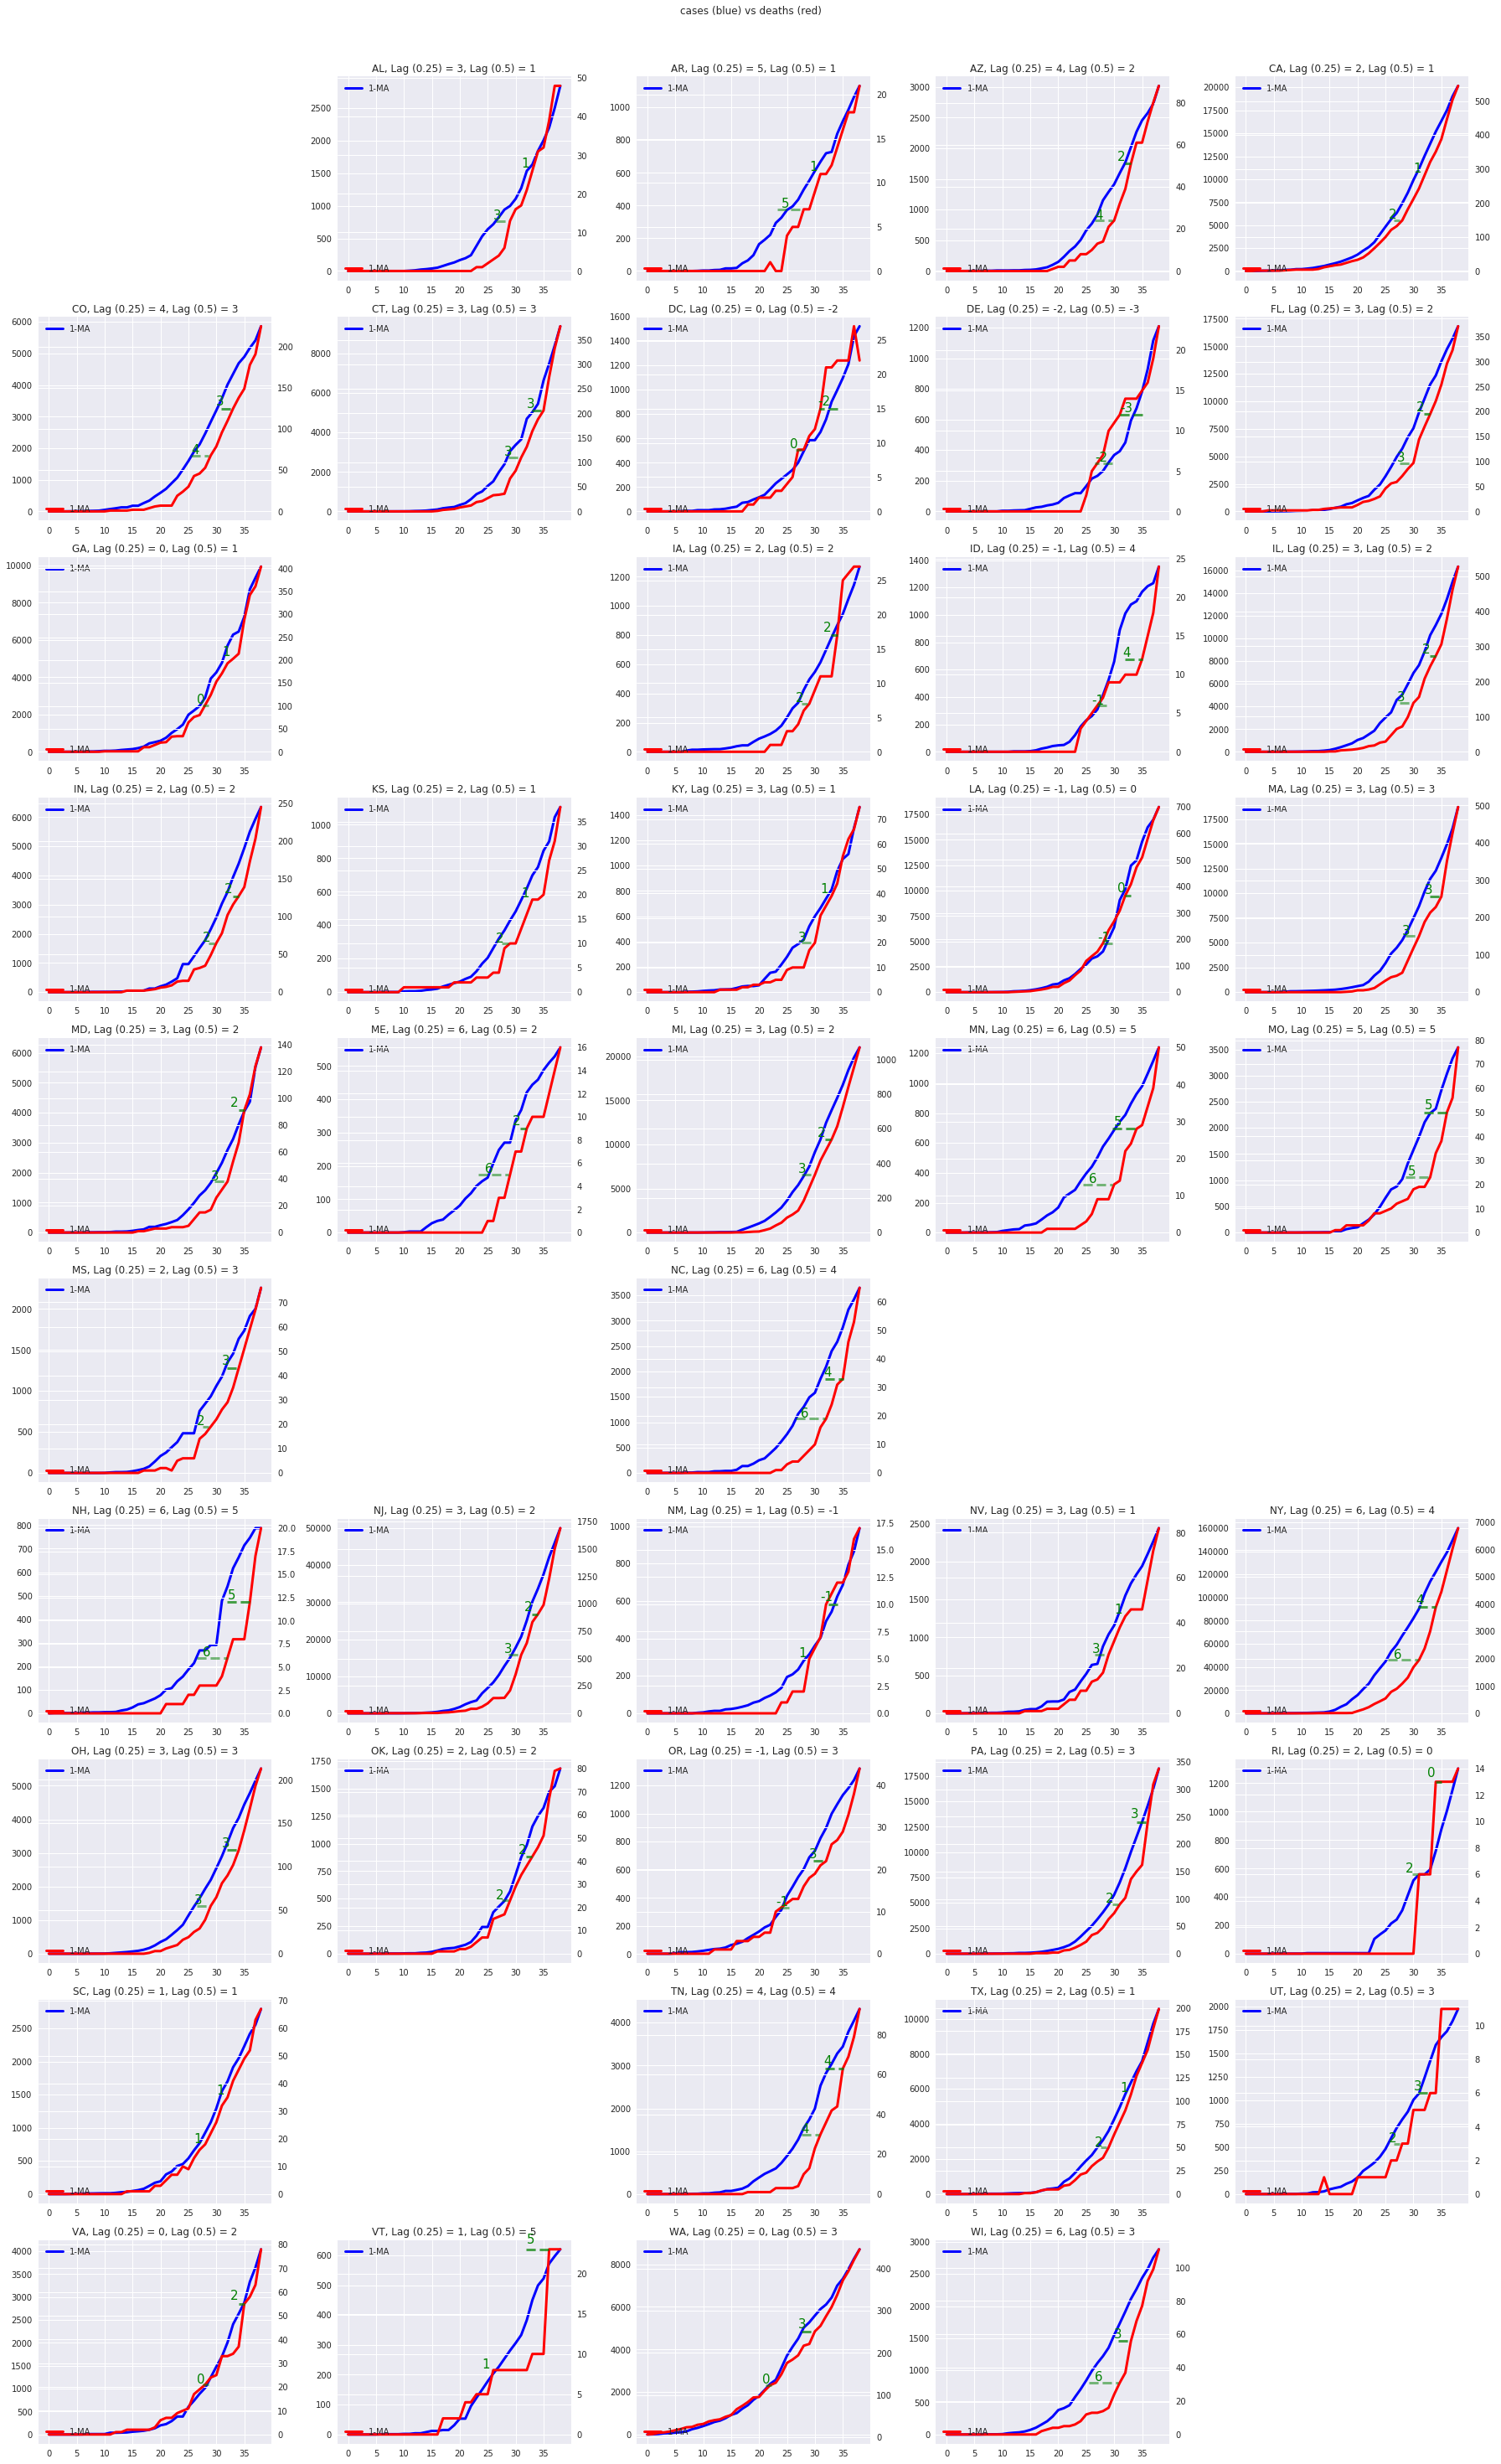

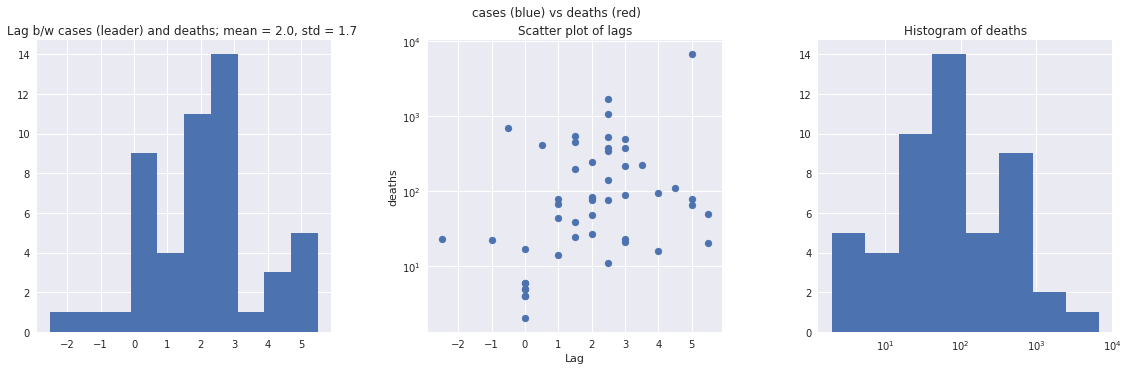

In [90]:
w = 1

f1, f2 = "cases", "deaths" 
num_plot = 50
deltas = np.zeros((num_plot, 2))
feat = np.zeros(num_plot)
f3 = 'deaths'

plt.figure(figsize=[25, 4*num_plot/5])
for j, state in enumerate(sdf.state.unique()[:num_plot]):
    feat[j] = sdf[sdf.state==state]["deaths"][j][-1]
    if feat[j]< 10:
        continue
    plt.subplot(num_plot/5, 5, j+1)
    
    y1 = pd.Series(sdf[sdf.state==state][f1][j][40:])
    plt.plot(y1, color='b', alpha=0.3)
    smooth_y1 =  y1.rolling(window=w)
    smooth_y1 = smooth_y1.mean()
    plt.plot(smooth_y1, color='b', linewidth=3., label='%d-MA'%w)
    x1, x2 = np.argmax(y1), np.argmax(smooth_y1)
#     plt.axvline(x= x2, color='b', alpha=0.6, linestyle='--', linewidth=3.)
#     plt.yscale('log')
    plt.legend(loc='upper left')
    
    ax = plt.gca().twinx()
    
    y2 = pd.Series(sdf[sdf.state==state][f2][j][40:])
    ax.plot(y2, color='r', alpha=0.3)
    smooth_y2 =  y2.rolling(window=w)
    smooth_y2 = smooth_y2.mean()
    ax.plot(smooth_y2, color='r', linewidth=3., label='%d-MA'%w)
    x3, x4 = np.argmax(y2), np.argmax(smooth_y2)
    plt.legend(loc='lower left')

    t1 = np.where(y1>=0.25*max(y1))[0][0]
    t2  = np.where(y2>=0.25*max(y2))[0][0]

    t11 = np.where(y1>=0.5*max(y1))[0][0]
    t22  = np.where(y2>=0.5*max(y2))[0][0]
    
    deltas[j, 0] = t2-t1
    deltas[j, 1] = t22-t11

    plt.axhline(y2[t2], (t1+0.5)/len(y2), (t2-0.5)/len(y2), color='g', linestyle='--', linewidth=3., alpha=0.5, )
    plt.text(x=(t1+t2-3)/2, y=y2[t2]*1.03, s=int(deltas[j, 0]), color='g', fontsize=15)

    plt.axhline(y2[t22], (t11+0.5)/len(y2), (t22-0.5)/len(y2), color='g', linestyle='--', linewidth=3., alpha=0.7, )
    plt.text(x=(t11+t22-3)/2, y=y2[t22]*1.03, s=int(deltas[j, 1]), color='g', fontsize=15)

    plt.title('%s, Lag (0.25) = %d, Lag (0.5) = %d'%(state, deltas[j, 0], deltas[j, 1]))
#     plt.yscale('log')
plt.tight_layout()
plt.suptitle('%s (blue) vs %s (red)'%(f1, f2), y=1.02)
plt.show()

plt.figure(figsize=[16, 5])
plt.subplot(131)
mean_deltas = np.mean(deltas, axis=1)
plt.hist(mean_deltas)
plt.title('Lag b/w %s (leader) and %s; mean = %.1f, std = %.1f '%(f1, f2, np.mean(mean_deltas), np.std(mean_deltas)))
    
plt.subplot(132)
plt.scatter(mean_deltas, feat)
plt.yscale('log')
plt.xlabel('Lag')
plt.ylabel(f3)
plt.title('Scatter plot of lags')

plt.subplot(133)
hist, bins = np.histogram(feat, bins=8)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.hist(feat, bins=logbins)
plt.xscale('log')
plt.title('Histogram of %s'%f3)
plt.suptitle('%s (blue) vs %s (red)'%(f1, f2), y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
sdf["total_deaths"] = feat

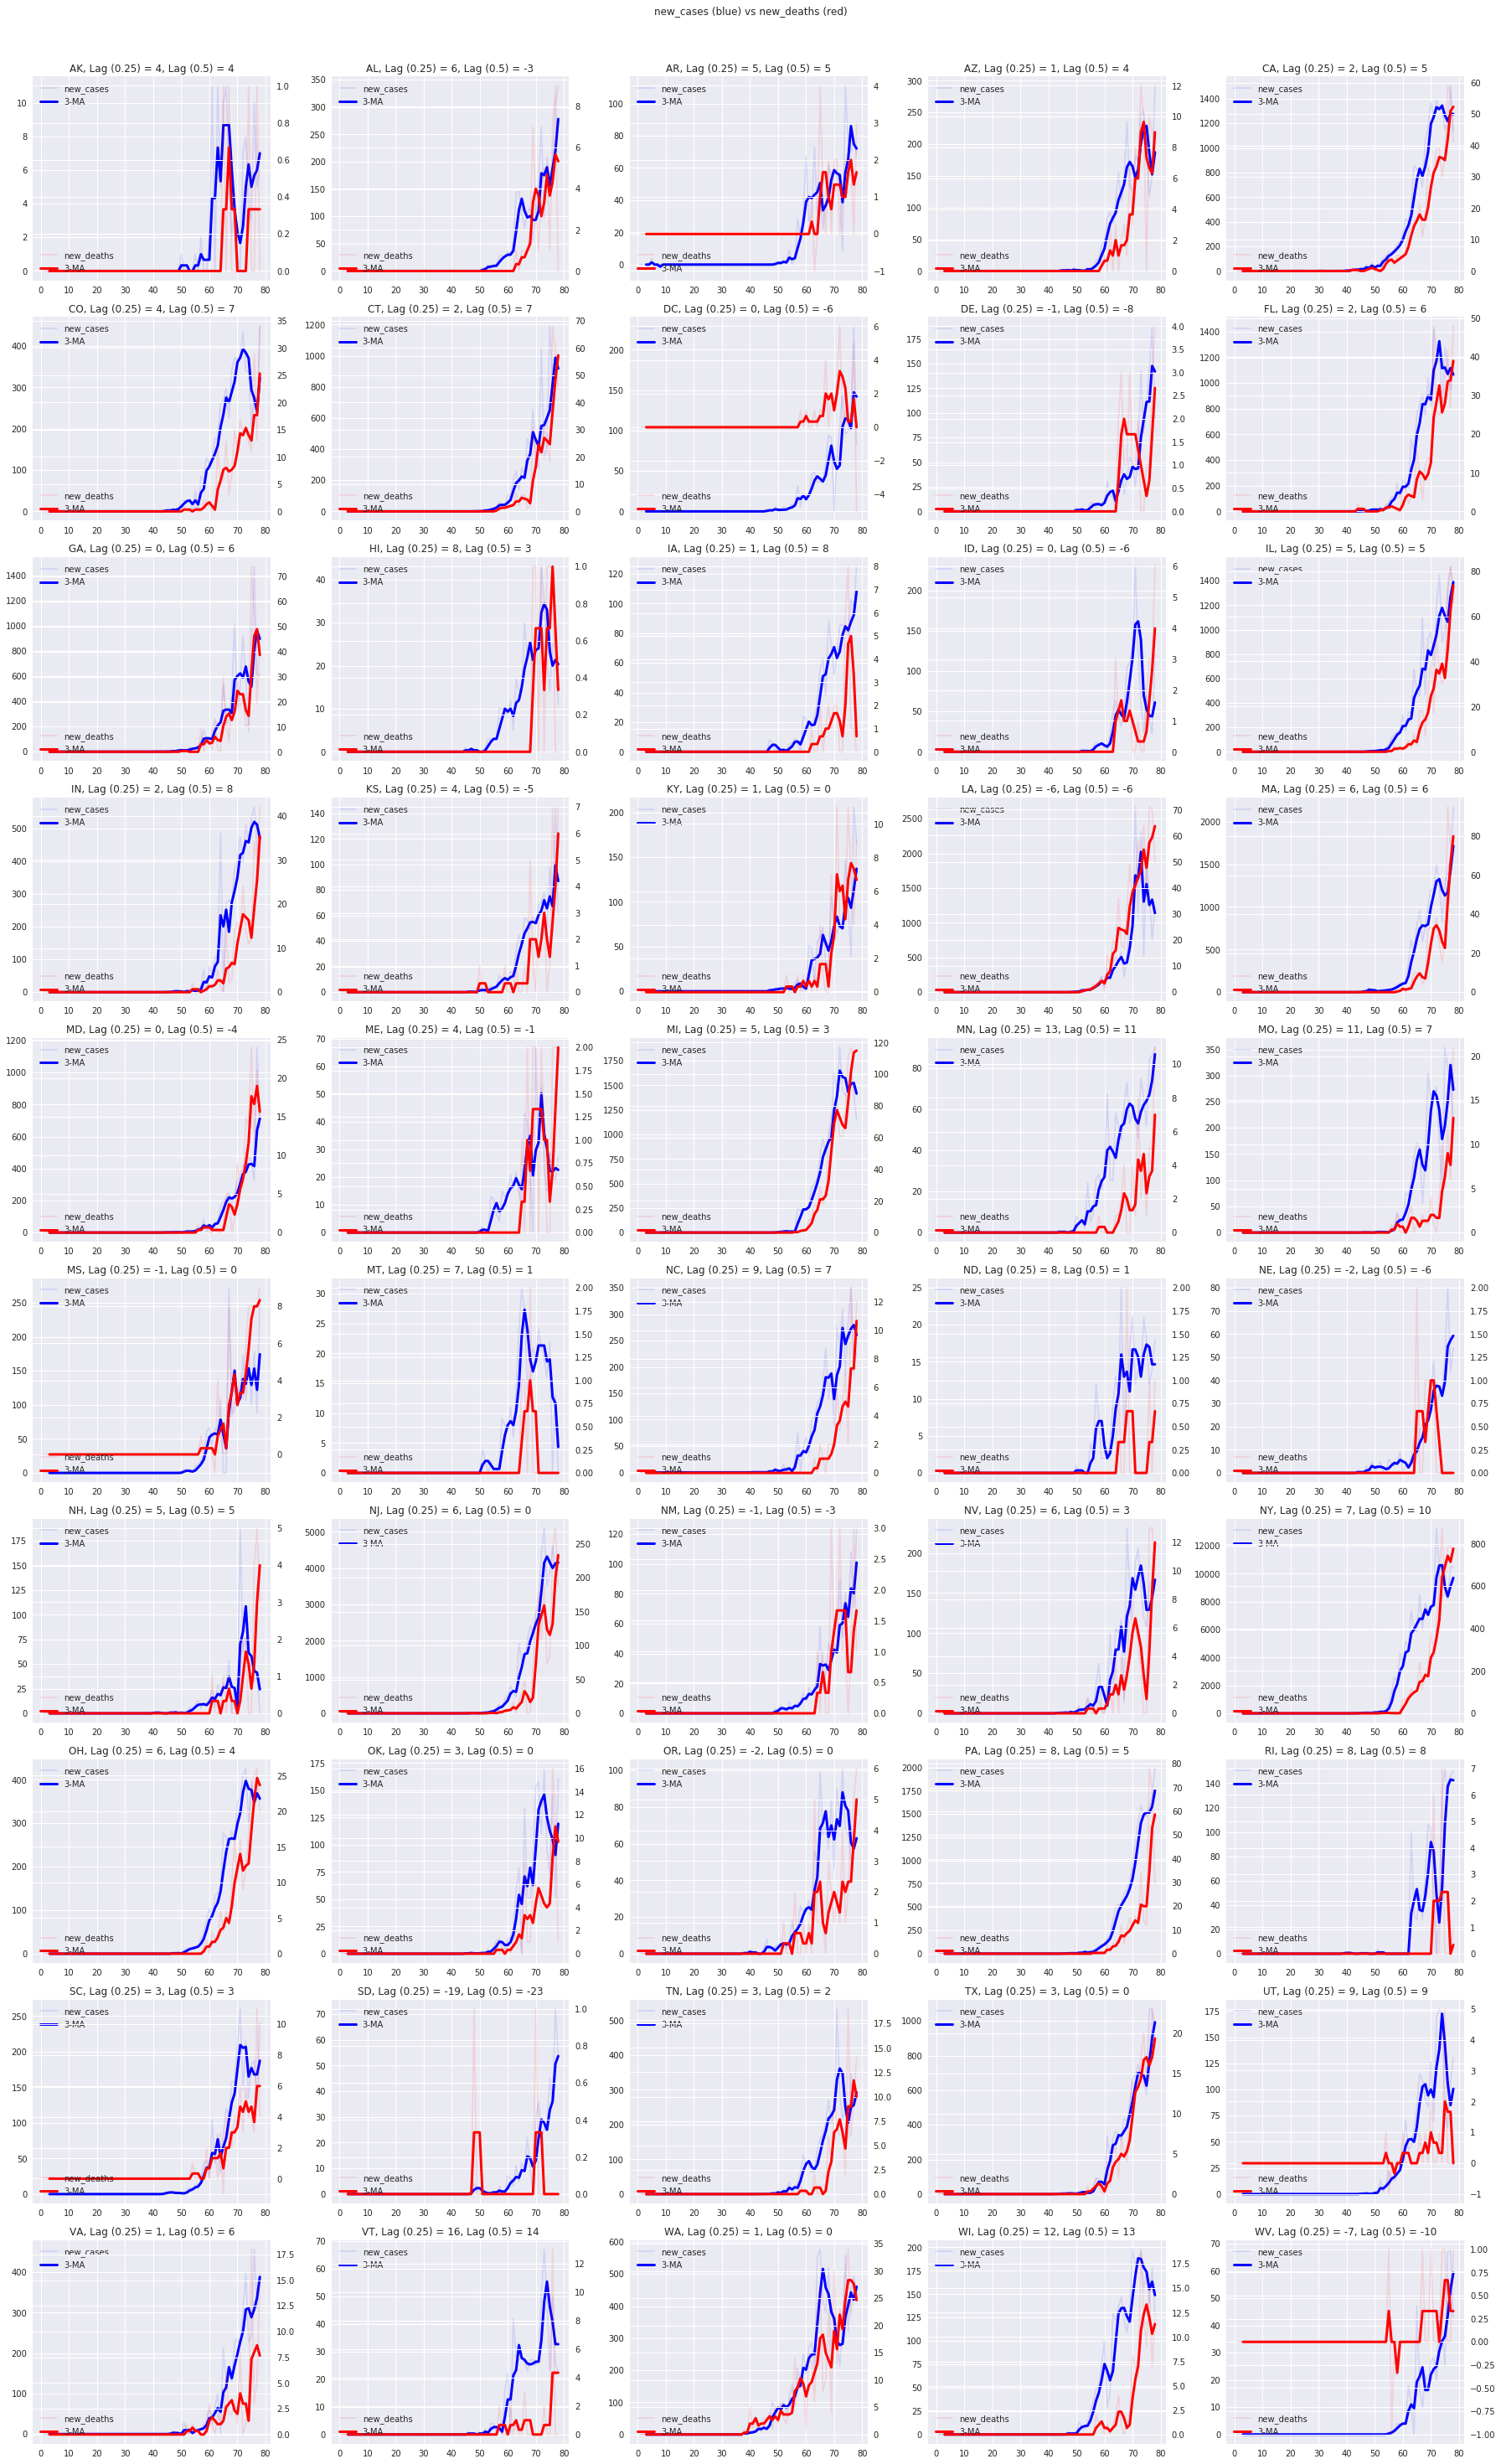

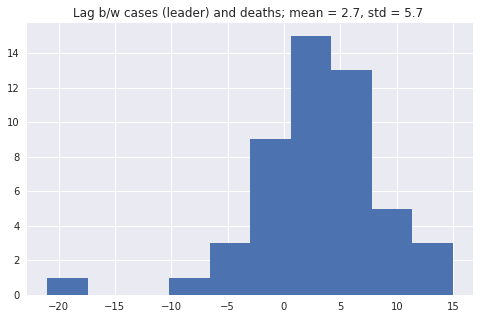

In [71]:
w = 3

prefix = 'new_'
f1, f2 = "cases", "deaths" 
num_plot = 50
deltas = np.zeros((num_plot, 2))

plt.figure(figsize=[25, 4*num_plot/5])
for j, state in enumerate(sdf.state.unique()[:num_plot]):
    plt.subplot(num_plot/5, 5, j+1)
    
    y1 = pd.Series(sdf[sdf.state==state][f1][j])
    if prefix == 'new_':
        y1 = (y1 - y1.shift(1))[1:]
        plt.plot(y1, color='b', alpha=0.1, label='%s'%prefix+f1)
    smooth_y1 =  y1.rolling(window=w)
    smooth_y1 = smooth_y1.mean()
    plt.plot(smooth_y1, color='b', linewidth=3., label='%d-MA'%w)
    x1, x2 = np.argmax(y1), np.argmax(smooth_y1)
#     plt.axvline(x= x2, color='b', alpha=0.6, linestyle='--', linewidth=3.)
#     plt.yscale('log')
    plt.legend(loc='upper left')
    
    ax = plt.gca().twinx()
    
    y2 = pd.Series(sdf[sdf.state==state][f2][j])
    if prefix == 'new_':
        y2 = (y2 - y2.shift(1))[1:]
        ax.plot(y2, color='r', alpha=0.1, label='%s'%prefix+f2)
    smooth_y2 =  y2.rolling(window=w)
    smooth_y2 = smooth_y2.mean()
    ax.plot(smooth_y2, color='r', linewidth=3., label='%d-MA'%w)
    
    x3, x4 = np.argmax(y2), np.argmax(smooth_y2)
    plt.legend(loc='lower left')

    t1 = np.where(y1>=0.25*max(y1))[0][0]
    t2  = np.where(y2>=0.25*max(y2))[0][0]

    t11 = np.where(y1>=0.5*max(y1))[0][0]
    t22  = np.where(y2>=0.5*max(y2))[0][0]
    
    deltas[j, 0] = t2-t1
    deltas[j, 1] = t22-t11

#     plt.axhline(y2[t2], (t1+0.5)/len(y2), (t2-0.5)/len(y2), color='g', linestyle='--', linewidth=3., alpha=0.5, )
#     plt.text(x=(t1+t2-3)/2, y=y2[t2]*1.03, s=int(deltas[j, 0]), color='g', fontsize=15)

#     plt.axhline(y2[t22], (t11+0.5)/len(y2), (t22-0.5)/len(y2), color='g', linestyle='--', linewidth=3., alpha=0.7, )
#     plt.text(x=(t11+t22-3)/2, y=y2[t22]*1.03, s=int(deltas[j, 1]), color='g', fontsize=15)

    plt.title('%s, Lag (0.25) = %d, Lag (0.5) = %d'%(state, deltas[j, 0], deltas[j, 1]))
#     plt.yscale('log')
plt.tight_layout()
plt.suptitle('%s (blue) vs %s (red)'%(prefix+f1, prefix+f2), y=1.02)
plt.show()

plt.figure(figsize=[8, 5])
# plt.subplot(131)
mean_deltas = np.mean(deltas, axis=1)
plt.hist(mean_deltas)
plt.title('Lag b/w %s (leader) and %s; mean = %.1f, std = %.1f '%(f1, f2, np.mean(mean_deltas), np.std(mean_deltas)))

# feat = np.zeros(len(dfg.groups.keys()))
# f3 = 'total_deaths'
# for j, grp in enumerate(dfg.groups.keys()):
#     group = dfg.get_group(grp).reset_index()
#     feat[j] = group[f3].tail(1).values[0]
# plt.subplot(132)
# plt.scatter(mean_deltas, feat)
# plt.yscale('log')
# plt.xlabel('Lag')
# plt.ylabel(f3)
# plt.title('Scatter plot of lags')

# plt.subplot(133)
# hist, bins = np.histogram(feat, bins=8)
# logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
# plt.hist(feat, bins=logbins)
# plt.xscale('log')
# plt.title('Histogram of %s'%f3)
# plt.suptitle('%s (blue) vs %s (red)'%(f1, f2), y=1.02)
# plt.tight_layout()
plt.show()

## Laplace Gaussian Modeling

In [93]:
sdf.state.unique()

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object)

In [91]:
def model_laplace(t, p, a, b):
    return(p*laplace.cdf(a*(t-b)))
def model_gauss(t, p, a, b):
    return(p*normal.cdf(a*(t-b)))

In [102]:
x_test

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

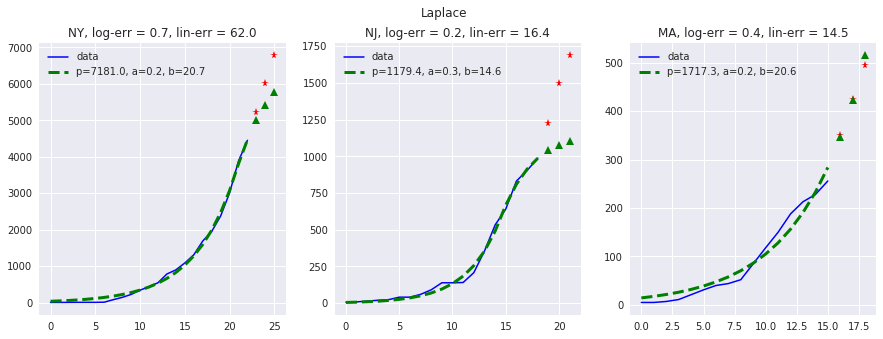

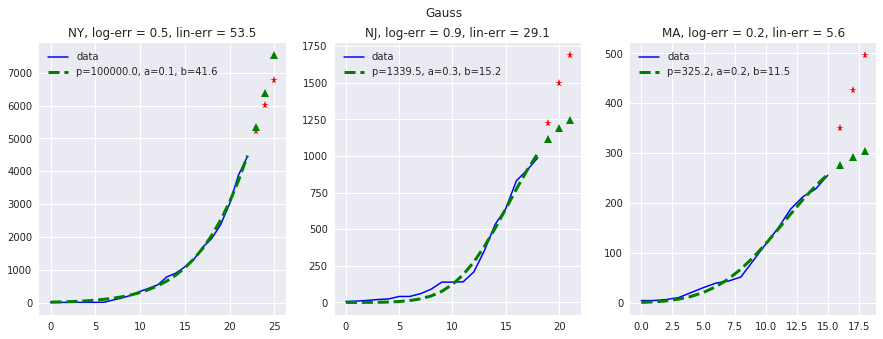

In [114]:
hold_out = 3
for model, label in  zip([model_laplace, model_gauss], ['Laplace', 'Gauss']):
    plt.figure(figsize=[15, 5])
    for j, state in enumerate(['NY', 'NJ', 'MA']):
        y_full = pd.Series(sdf[sdf.state==state]["deaths"].values[0])
        y_full = y_full[y_full>=4]
        x_full = np.arange(0, len(y_full))
        y_train, y_test = y_full[:-hold_out], y_full[-hold_out:]
        x_train, x_test = x_full[:-hold_out], x_full[-hold_out:]
        if len(y) > 5:
            popt, pcov = curve_fit(model, x_train, y_train, bounds=(0., [100000, 2., 100.]), p0=[10000, 1., 5.])
            y_fit =  model(x_train, *popt)
            plt.subplot(1, 3, j+1)
            plt.plot(x_train, y_train, 'b-', label='data', linewidth=1.5)
            plt.plot(x_train, y_fit, 'g--', linewidth=3., label='p=%.1f, a=%.1f, b=%.1f' % tuple(popt))
            plt.plot(x_test, y_test, 'r*', markersize=8.)
            plt.plot(x_test, model(x_test, *popt), 'g^', markersize=8.)
            l1_error_log_y = np.mean(np.abs(np.log(1+y_train)-np.log(1+y_fit)))
            l1_error = np.mean(np.abs(y_train-y_fit))
            plt.legend()
            plt.title('%s, log-err = %.1f, lin-err = %.1f'%(state, l1_error_log_y, l1_error))
    plt.suptitle(label)
    plt.show()